# **Machine Learning: Project Part 2**

---

**Author: Damien Farrell**

---

## **Project Part 2: Seal Call Discrimination**

### **Objective**
The aim of this project is to analyze a recorded dataset to investigate the feasibility of discriminating between different seal calls. The project is structured in steps to build a machine learning model that can potentially detect seal calls from audio recordings. While creating a fully functional detector is the ultimate goal, it may not be the final outcome of this project.

#### **Step A: Data Pre-processing**

This step is completed in notebook `data_preprocessing.ipynb`. The file `processed_data.pkl` was produced from this notebook.

#### **Step B: Model Training**
1. **Dataset Utilisation**:
   - Use the prepared spectrogram dataset to train the machine learning model.

3. **Evaluation**:
   - Test the model’s performance on a separate test dataset.

#### **Step C: Refine**
1. **Parameter Tuning**:
   - Adjust parameters in the data extraction/spectrogram creation process (e.g., `nfft`, `noverlap`).
   - Manage computational costs by splitting `.wav` files using tools like `pydub`.

2. **Validation**:
   - Apply the Rupe B/No Call classifier on an entire `.wav` file (held back during training).
   - Ensure no false positives due to the presence of other annotated calls.

In [108]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder

---

### **Step B: Model Training** 

---

In [109]:
# Load in processed data

df = pd.read_pickle('processed_data.pkl')

df

,Selection,View,Channel,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Delta Time (s),Delta Freq (Hz),Avg Power Density (dB FS/Hz),...,Annotation_G rupe,Annotation_Growl B,Annotation_HS Groan,Annotation_Moan,Annotation_Rupe A,Annotation_Rupe B,Annotation_Rupe C,Annotation_Trrot,Annotation_Type 4 A,Annotation_no-call
0,1,Spectrogram 1,1,4.136987,4.657535,173.956,286.792,0.520500,112.836,-82.85,...,True,False,False,False,False,False,False,False,False,False
1,2,Spectrogram 1,1,3.789955,4.264841,371.419,451.345,0.474900,79.926,-92.16,...,True,False,False,False,False,False,False,False,False,False
2,3,Spectrogram 1,1,14.840188,15.406398,136.660,445.248,0.566200,308.588,-88.96,...,True,False,False,False,False,False,False,False,False,False
3,4,Spectrogram 1,1,24.543802,25.082615,167.519,392.347,0.538800,224.828,-86.10,...,True,False,False,False,False,False,False,False,False,False
4,5,Spectrogram 1,1,35.989220,36.573694,119.027,436.431,0.584500,317.405,-80.18,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3737,None,None,None,251.535333,252.597042,NaN,NaN,1.061708,NaN,NaN,...,False,False,False,False,False,False,False,False,False,True
3738,None,None,None,108.537292,109.599000,NaN,NaN,1.061708,NaN,NaN,...,False,False,False,False,False,False,False,False,False,True
3739,None,None,None,421.677292,422.739000,NaN,NaN,1.061708,NaN,NaN,...,False,False,False,False,False,False,False,False,False,True
3740,None,None,None,335.192833,336.254542,NaN,NaN,1.061708,NaN,NaN,...,False,False,False,False,False,False,False,False,False,True


Encode labels

In [110]:
# Get the shapes
shapes = df['snippet_spectrogram'].apply(lambda x: x.shape if isinstance(x, np.ndarray) else None)

# Count unique shapes
print("Unique shapes in 'snippet_spectrogram':")
print(shapes.value_counts())

Unique shapes in 'snippet_spectrogram':
snippet_spectrogram
(42, 84)    3742
Name: count, dtype: int64


In [111]:
X = df[['snippet_spectrogram']].to_numpy()

print(type(X))
print(X.shape)
print(X)

<class 'numpy.ndarray'>
(3742, 1)
[[array([[1.05691223e+01, 4.71264744e+00, 1.27377617e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [1.26917324e+01, 4.23436451e+00, 1.20147288e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [5.69212770e+00, 1.91194272e+00, 7.23596334e-01, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [2.43534474e-03, 3.54114966e-03, 2.13033967e-02, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [5.22652222e-03, 2.88478262e-03, 1.10955769e-02, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [4.52843541e-03, 7.73686497e-03, 8.82265996e-03, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])   ]
 [array([[4.23982964e+01, 5.56812668e+01, 8.33615417e+01, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [4.65100021e+01, 5.13544350e+01, 8.94422607e+01, ...,
          0.00000000e+00, 0.00

In [112]:
print(type(X[0]))
print(X[0].shape)
print(X[0])

<class 'numpy.ndarray'>
(1,)
[array([[1.05691223e+01, 4.71264744e+00, 1.27377617e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.26917324e+01, 4.23436451e+00, 1.20147288e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [5.69212770e+00, 1.91194272e+00, 7.23596334e-01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [2.43534474e-03, 3.54114966e-03, 2.13033967e-02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [5.22652222e-03, 2.88478262e-03, 1.10955769e-02, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [4.52843541e-03, 7.73686497e-03, 8.82265996e-03, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])   ]


In [113]:
print(type(X[0][0]))
print(X[0][0].shape)
print(X[0][0])

<class 'numpy.ndarray'>
(42, 84)
[[1.05691223e+01 4.71264744e+00 1.27377617e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.26917324e+01 4.23436451e+00 1.20147288e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.69212770e+00 1.91194272e+00 7.23596334e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.43534474e-03 3.54114966e-03 2.13033967e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.22652222e-03 2.88478262e-03 1.10955769e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.52843541e-03 7.73686497e-03 8.82265996e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [114]:
# "Flatten" the (3742, 1) array to (3742,)
X = X.ravel()
print(X.shape)

(3742,)


In [115]:
# Stack along a new axis to get shape (3742, 42, 84)
X = np.stack(X, axis=0)
print(X.shape) 

(3742, 42, 84)


In [116]:
# Add need a channel dimension: (3742, 42, 84, 1)
X = np.expand_dims(X, axis=-1)
print(X.shape)  

(3742, 42, 84, 1)


In [117]:
from sklearn.model_selection import train_test_split

X = np.stack(df['snippet_spectrogram'].values)
y = df[[col for col in df.columns if col.startswith("Annotation_")]]  # Select annotation columns

# `y` contains one-hot encoded labels
stratify_labels = y.idxmax(axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=stratify_labels
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (2993, 42, 84) Test shape: (749, 42, 84)


In [118]:
stratify_labels

0        Annotation_G rupe
1        Annotation_G rupe
2        Annotation_G rupe
3        Annotation_G rupe
4        Annotation_G rupe
               ...        
3737    Annotation_no-call
3738    Annotation_no-call
3739    Annotation_no-call
3740    Annotation_no-call
3741    Annotation_no-call
Length: 3742, dtype: object

In [119]:
num_classes = len(stratify_labels.unique())

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(42, 84, 1)))
model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))


In [120]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 42, 84, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 21, 42, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 21, 42, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 10, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 10, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 5, 10, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 434,314 (1.66 MB)

 Trainable params: 434,314 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

In [121]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),  #from_logits=False as softmax is on the output of the CNN
    metrics=['accuracy'],
)

In [122]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5617 - loss: 80.9721 - val_accuracy: 0.6160 - val_loss: 8.4237
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6233 - loss: 2.3368 - val_accuracy: 0.6728 - val_loss: 3.5155
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6885 - loss: 0.9211 - val_accuracy: 0.8297 - val_loss: 4.7633
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7920 - loss: 0.5809 - val_accuracy: 0.8364 - val_loss: 4.3129
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8629 - loss: 0.4187 - val_accuracy: 0.8598 - val_loss: 5.9035
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8771 - loss: 0.3663 - val_accuracy: 0.8531 - val_loss: 4.6443
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8816 - loss: 0.3536 - val_accuracy: 0.8731 - val_loss: 6.6069
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8916 - loss: 0.3568 - val_accuracy: 0.8748 - 

In [123]:
model.evaluate(X_test, y_test, return_dict=True)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9235 - loss: 437.8925


{'accuracy': 0.9158878326416016, 'loss': 525.048583984375}

In [124]:
def plot_loss(history, which='loss'):
    plt.plot(history.history[which], label='train')
    try:
        plt.plot(history.history['val_'+which], label='validation')
    except:
        None
    plt.xlabel('Epoch')
    plt.ylabel(which)
    plt.legend()
    plt.grid(True)

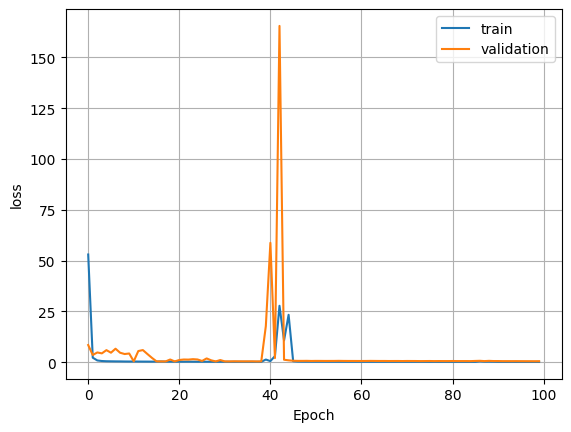

In [125]:
plot_loss(history)

---

### **Step C: Refine**

---

---

### **References**

1. [Bird Song Dataset on Kaggle](https://www.kaggle.com/code/sophiagnetneva/cnn-for-sound-classification-bird-calls-90)





---

# END